## Imports

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from utils import find_knn_per_class, apply_smote, plot_tsne, plot_pca, plot_umap
from sklearn.metrics import classification_report, confusion_matrix


C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data preprocessing

In [2]:
data = np.load("data_files/full_acoustic_dataset.npz", allow_pickle=True)
labeled_x = data['labeled_x']
labeled_y = data['labeled_y']
unlabeled_x = data['unlabeled_x']
unlabeled_meta = data['unlabeled_meta']

all_new_x = []
all_new_y = []

for cls in np.unique(labeled_y):
    results, new_x, new_y, unlabeled_x, unlabeled_meta = find_knn_per_class(
        labeled_x, labeled_y,
        unlabeled_x, unlabeled_meta,
        target_class=cls,
        max_K=10,
        distance_threshold=500
    )
    print(f"Class {cls}: added {len(new_y)} new samples.")
    all_new_x.append(new_x)
    all_new_y.append(new_y)

pseudo_x = np.vstack(all_new_x)
pseudo_y = np.concatenate(all_new_y)
print("Final up-sampled size:", pseudo_x.shape)
print("Remaining unlabeled:", unlabeled_x.shape)

all_labeled_x = np.concatenate([labeled_x, pseudo_x])
all_labeled_y = np.concatenate([labeled_y, pseudo_y])

X_resampled, y_resampled = apply_smote(all_labeled_x, all_labeled_y)

train_indices, val_indices = train_test_split(
    range(len(X_resampled)), test_size=0.3, random_state=42, stratify=y_resampled
)
train_x, train_y = X_resampled[train_indices], y_resampled[train_indices]
val_x, val_y = X_resampled[val_indices], y_resampled[val_indices]


Class 0: added 129 new samples.
Class 1: added 2733 new samples.
Final up-sampled size: (2862, 25)
Remaining unlabeled: (13141621, 25)
Original class distribution: Counter({1: 3061, 0: 302})
Resampled class distribution: Counter({0: 3061, 1: 3061})


## Random forest

In [4]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(train_x, train_y)

probs = rf_model.predict_proba(val_x)
preds = rf_model.predict(val_x)

confidence_threshold = 0.9
final_preds = np.array([
    p if max(prob) >= confidence_threshold else -1
    for p, prob in zip(preds, probs)
])

valid_mask = final_preds != -1
filtered_preds = final_preds[valid_mask]
filtered_true = val_y[valid_mask]

print("Evaluation on confident predictions only:")
print(f"Accuracy: {accuracy_score(filtered_true, filtered_preds):.4f}")
print(f"F1 Score (macro): {f1_score(filtered_true, filtered_preds, average='macro'):.4f}")
print(f"F1 Score (weighted): {f1_score(filtered_true, filtered_preds, average='weighted'):.4f}")

print(f"Retained {len(filtered_preds)} of {len(val_y)} validation instances after rejection.")


Evaluation on confident predictions only:
Accuracy: 1.0000
F1 Score (macro): 1.0000
F1 Score (weighted): 1.0000
Retained 1315 of 1837 validation instances after rejection.


C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


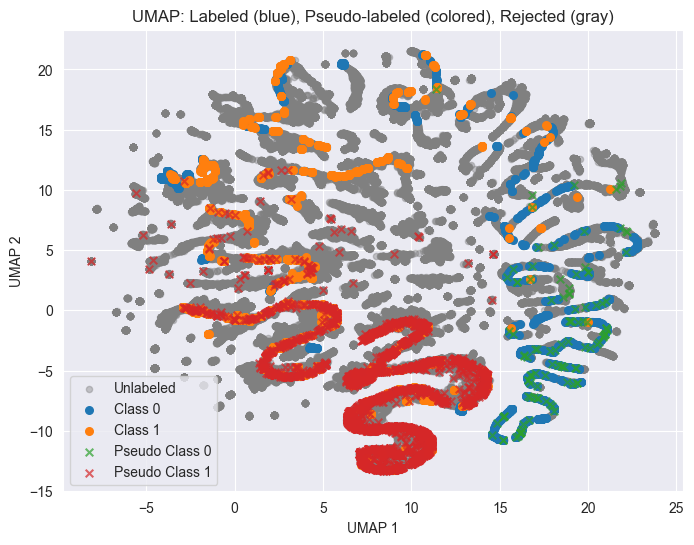

In [6]:
np.random.seed(42)
sample_indices = np.random.choice(len(unlabeled_x), 100000, replace=False)
sampled_unlabeled_x = unlabeled_x[sample_indices]

sampled_probs = rf_model.predict_proba(sampled_unlabeled_x)
sampled_preds = rf_model.predict(sampled_unlabeled_x)

confidence_threshold = 0.99
confident_mask = np.max(sampled_probs, axis=1) >= confidence_threshold
pseudo_x = sampled_unlabeled_x[confident_mask]
pseudo_y = sampled_preds[confident_mask]

plot_umap(
    labeled_x=train_x,           
    labeled_y=train_y,
    unlabeled_x=sampled_unlabeled_x[~confident_mask], 
    pseudo_x=pseudo_x,
    pseudo_y=pseudo_y,
    title="UMAP: Labeled (blue), Pseudo-labeled (colored), Rejected (gray)"
)


In [7]:

# === Per-Class Evaluation ===
print("\nPer-Class Classification Report:")
print(classification_report(filtered_true, filtered_preds, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(filtered_true, filtered_preds))



Per-Class Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       641
           1     1.0000    1.0000    1.0000       674

    accuracy                         1.0000      1315
   macro avg     1.0000    1.0000    1.0000      1315
weighted avg     1.0000    1.0000    1.0000      1315

Confusion Matrix:
[[641   0]
 [  0 674]]


## XGBoost

In [8]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=10,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    eval_metric='logloss'
)

xgb_model.fit(train_x, train_y)

probs = xgb_model.predict_proba(val_x)
preds = xgb_model.predict(val_x)

confidence_threshold = 0.9
final_preds = [p if max(prob) >= confidence_threshold else -1 for p, prob in zip(preds, probs)]

final_preds = np.array(final_preds)
val_y = np.array(val_y)
valid_mask = final_preds != -1
filtered_preds = final_preds[valid_mask]
filtered_true = val_y[valid_mask]

print("Evaluation on confident predictions only:")
print(f"Accuracy: {accuracy_score(filtered_true, filtered_preds):.4f}")
print(f"F1 Score (macro): {f1_score(filtered_true, filtered_preds, average='macro'):.4f}")
print(f"F1 Score (weighted): {f1_score(filtered_true, filtered_preds, average='weighted'):.4f}")

print(f"Retained {len(filtered_preds)} of {len(val_y)} validation instances after rejection.")


Evaluation on confident predictions only:
Accuracy: 0.9983
F1 Score (macro): 0.9983
F1 Score (weighted): 0.9983
Retained 1790 of 1837 validation instances after rejection.


C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


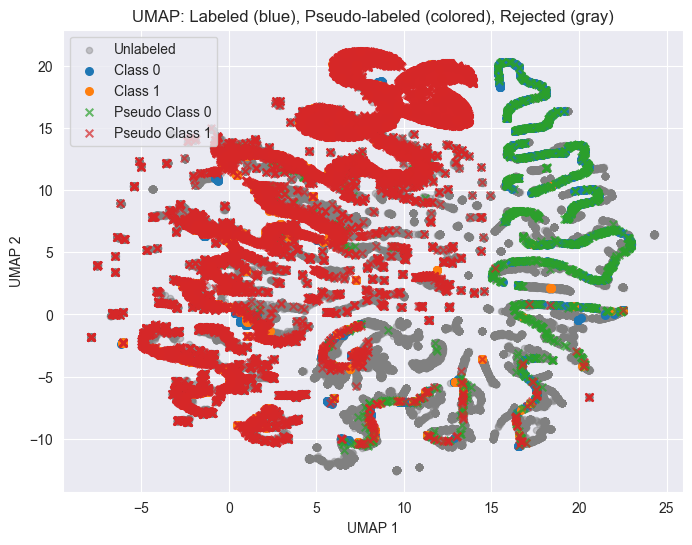

In [9]:
sampled_probs = xgb_model.predict_proba(sampled_unlabeled_x)
sampled_preds = xgb_model.predict(sampled_unlabeled_x)

confidence_threshold = 0.99
confident_mask = np.max(sampled_probs, axis=1) >= confidence_threshold
pseudo_x = sampled_unlabeled_x[confident_mask]
pseudo_y = sampled_preds[confident_mask]
plot_umap(
    labeled_x=train_x,           
    labeled_y=train_y,
    unlabeled_x=sampled_unlabeled_x[~confident_mask], 
    pseudo_x=pseudo_x,
    pseudo_y=pseudo_y,
    title="UMAP: Labeled (blue), Pseudo-labeled (colored), Rejected (gray)"
)

In [10]:

# === Per-Class Evaluation ===
print("\nPer-Class Classification Report:")
print(classification_report(filtered_true, filtered_preds, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(filtered_true, filtered_preds))



Per-Class Classification Report:
              precision    recall  f1-score   support

           0     0.9967    1.0000    0.9983       903
           1     1.0000    0.9966    0.9983       887

    accuracy                         0.9983      1790
   macro avg     0.9983    0.9983    0.9983      1790
weighted avg     0.9983    0.9983    0.9983      1790

Confusion Matrix:
[[903   0]
 [  3 884]]
